In [1]:
from pymongo import MongoClient
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017')
db = client['collaborativefilteringtest']  # Database name
users_collection = db['users']
posts_collection = db['posts']
likes_collection = db['likes']


post_id:  {'66a1b0f10aa35f5c18c123a1': 0, '66a1b0f10aa35f5c18c123a2': 1, '66a1b0f10aa35f5c18c123a3': 2, '66a1b0f10aa35f5c18c123a4': 3, '66a1b0f10aa35f5c18c123a5': 4, '66a1b0f10aa35f5c18c123a6': 5, '66a1b0f10aa35f5c18c123a7': 6, '66a1b0f10aa35f5c18c123a9': 7, '66a1b0f10aa35f5c18c123aa': 8, '66a1b0f10aa35f5c18c123ab': 9, '66a1b0f10aa35f5c18c123ac': 10, '66a1b0f10aa35f5c18c123ad': 11, '66a1b0f10aa35f5c18c123ae': 12, '66a1b0f10aa35f5c18c123af': 13, '66a1b0f10aa35f5c18c123b0': 14, '66a1b0f10aa35f5c18c123b1': 15, '66a1b0f10aa35f5c18c123b2': 16, '66a1b0f10aa35f5c18c123b3': 17, '66a1b0f10aa35f5c18c123b4': 18, '669f6256e631f6bd2e434970': 19, '669f668ae631f6bd2e434971': 20, '66a0af5160cb65cbc9feb876': 21} user_ids:  {'669c0b8e2ea43ac3b0c83bd2': 0, '669c0b8e2ea43ac3b0c83bd3': 1, '669c0b8e2ea43ac3b0c83bd4': 2, '669c0b8e2ea43ac3b0c83bd5': 3, '669c0b8e2ea43ac3b0c83bd6': 4, '669c0b8e2ea43ac3b0c83bd7': 5, '669c0b8e2ea43ac3b0c83bd8': 6, '669c0b8e2ea43ac3b0c83bd9': 7, '669c0b8e2ea43ac3b0c83bda': 8, '669

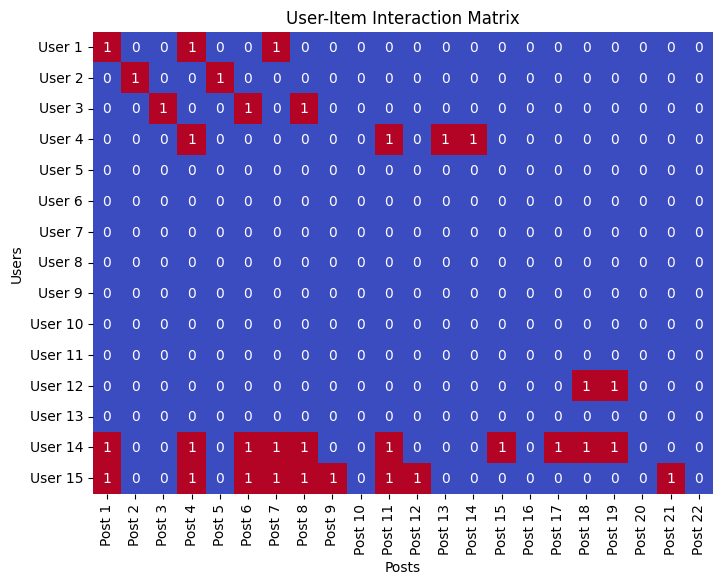

In [2]:
# Fetch data from MongoDB
users = list(users_collection.find())
posts = list(posts_collection.find())
likes = list(likes_collection.find())


# Create mappings for user and post IDs (using string IDs)
user_ids = {str(user['_id']): idx for idx, user in enumerate(users)}
post_ids = {str(post['_id']): idx for idx, post in enumerate(posts)}

print('post_id: ', post_ids , 'user_ids: ', user_ids)

# Create rating matrix
num_users = len(users)
num_posts = len(posts)
ratings_matrix = np.zeros((num_users, num_posts))

for like in likes:
    user_id_str = str(like['user_id'])
    post_id_str = str(like['post_id'])
    
    user_idx = user_ids.get(user_id_str)
    post_idx = post_ids.get(post_id_str)
    
    if user_idx is not None and post_idx is not None:
        ratings_matrix[user_idx, post_idx] = 1

# Convert matrix to DataFrame for pivot-like operations
ratings_df = pd.DataFrame(ratings_matrix, index=[f"User {i+1}" for i in range(num_users)], columns=[f"Post {i+1}" for i in range(num_posts)])

# Visualisasi matriks interaksi
plt.figure(figsize=(8, 6))
sns.heatmap(ratings_df, annot=True, cmap='coolwarm', cbar=False)
plt.title('User-Item Interaction Matrix')
plt.xlabel('Posts')
plt.ylabel('Users')
plt.show()

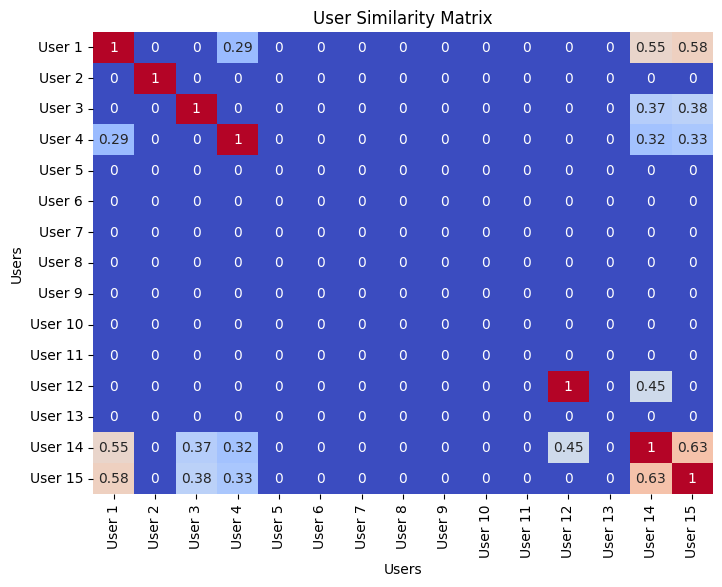

array([17, 18, 16, 14,  2, 12, 13, 19, 21, 20])

In [3]:

# Calculate cosine similarity between users
user_similarity = cosine_similarity(ratings_matrix)

# Convert similarity to DataFrame for better readability
similarity_df = pd.DataFrame(user_similarity, index=[f"User {i+1}" for i in range(num_users)], columns=[f"User {i+1}" for i in range(num_users)])

# Visualisasi matriks kesamaan pengguna
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', cbar=False)
plt.title('User Similarity Matrix')
plt.xlabel('Users')
plt.ylabel('Users')
plt.show()

# Function to recommend posts for a given user based on similar users' likes
def recommend_posts(user_idx, num_recommendations=5):
    sim_scores = user_similarity[user_idx]
    similar_users = np.argsort(sim_scores)[::-1][1:]  # Exclude the user itself
    
    post_scores = np.zeros(num_posts)
   
    for similar_user in similar_users:
        post_scores += sim_scores[similar_user] * ratings_matrix[similar_user]
    
    post_scores[ratings_matrix[user_idx] > 0] = 0
    
    recommended_post_indices = np.argsort(post_scores)[::-1][:num_recommendations]
    return recommended_post_indices

recommend_posts(user_idx, num_recommendations=10)

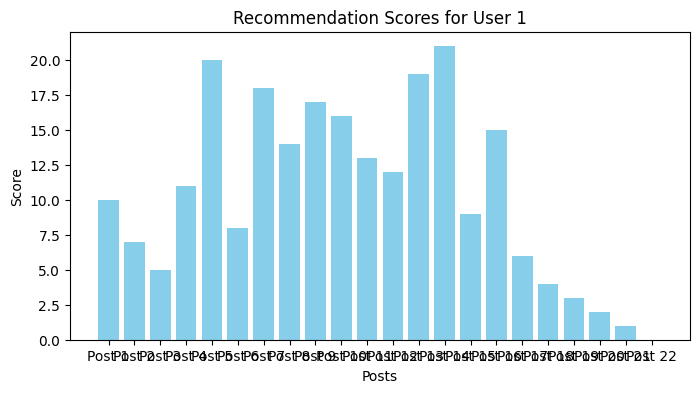

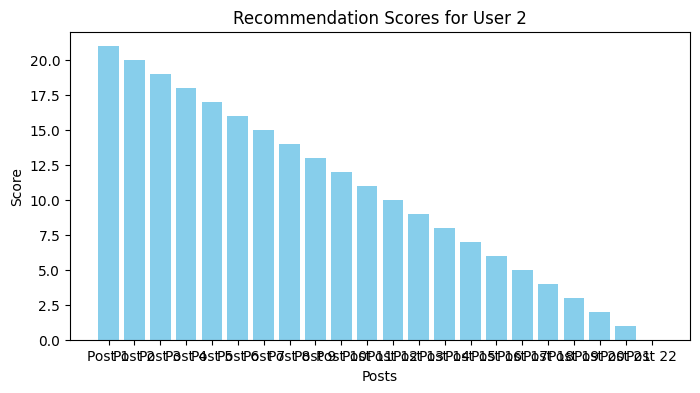

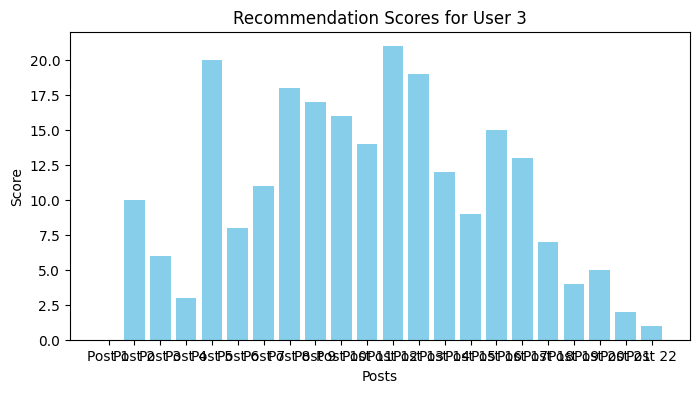

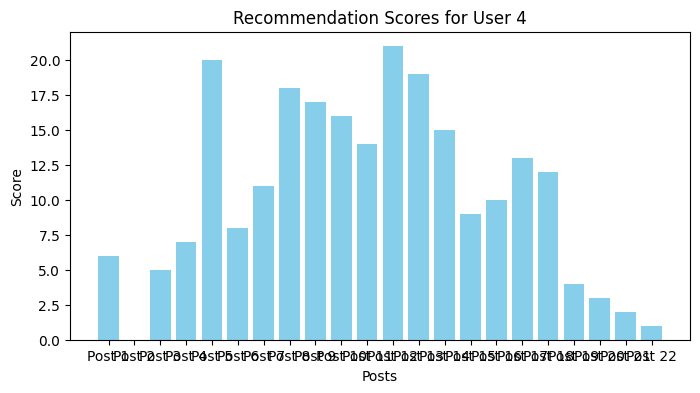

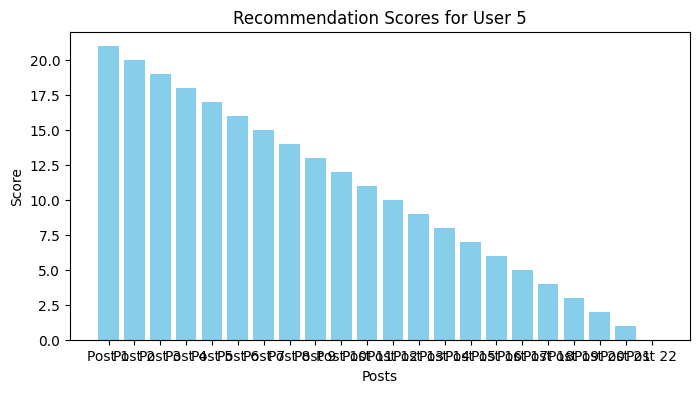

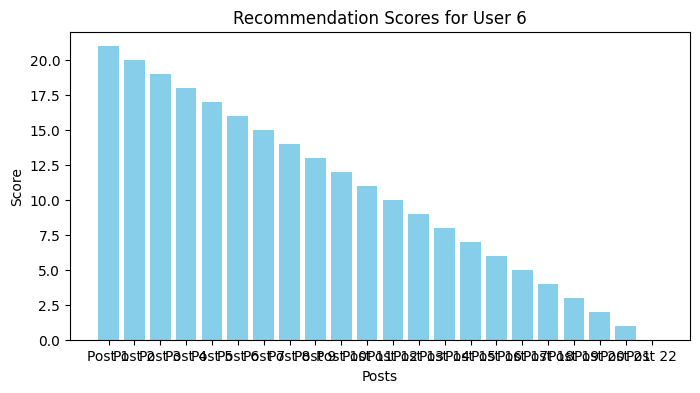

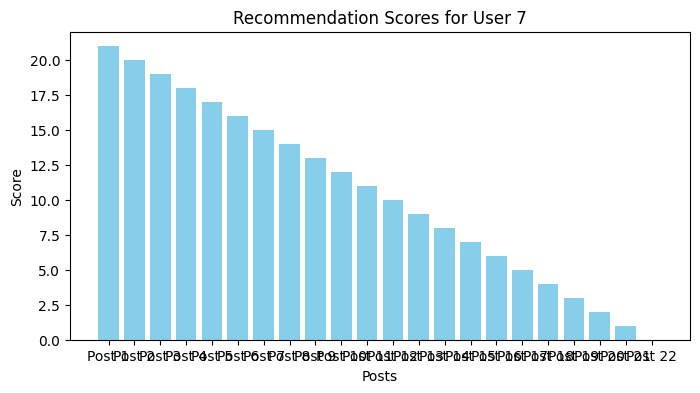

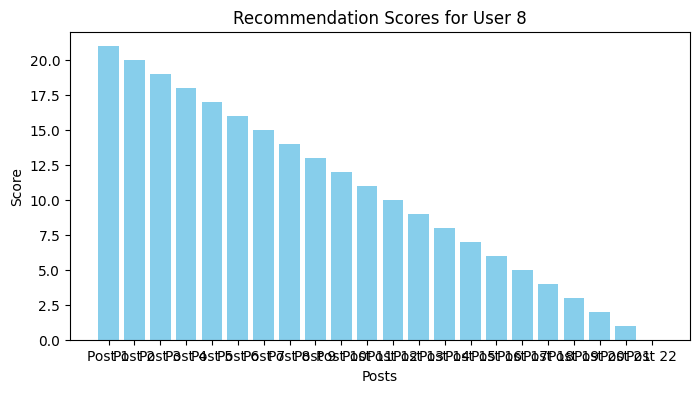

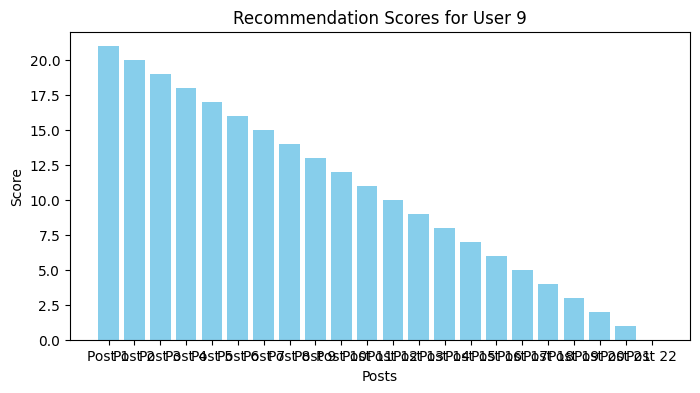

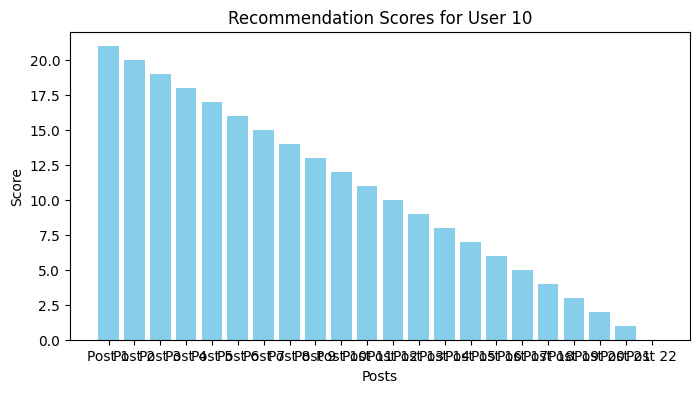

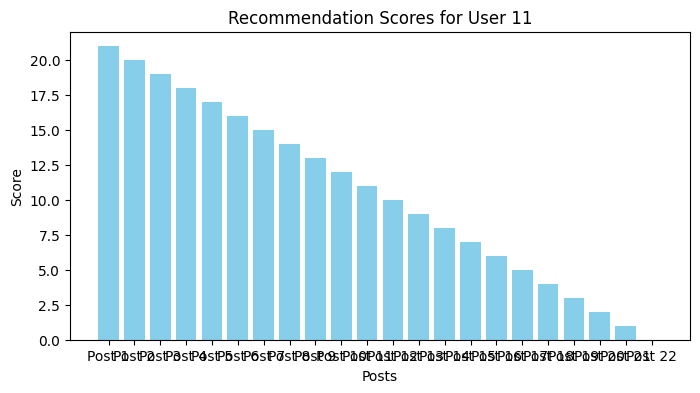

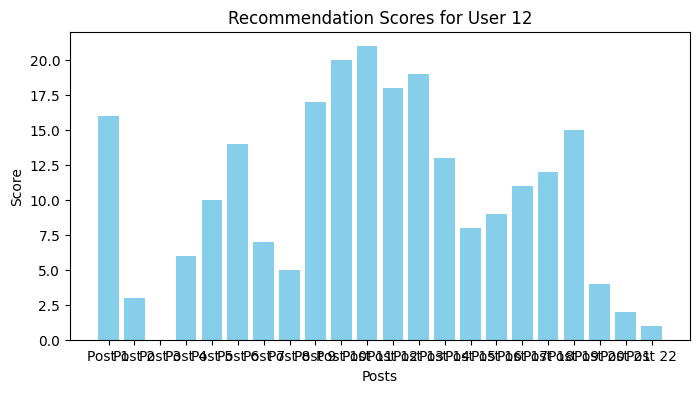

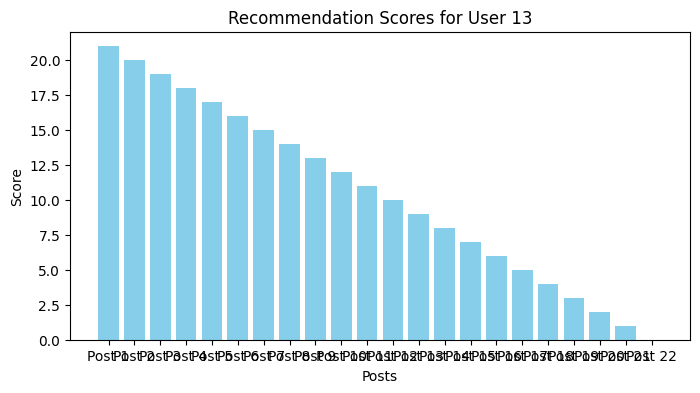

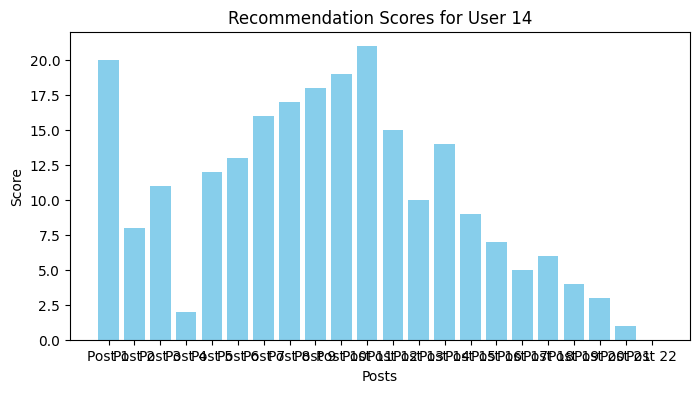

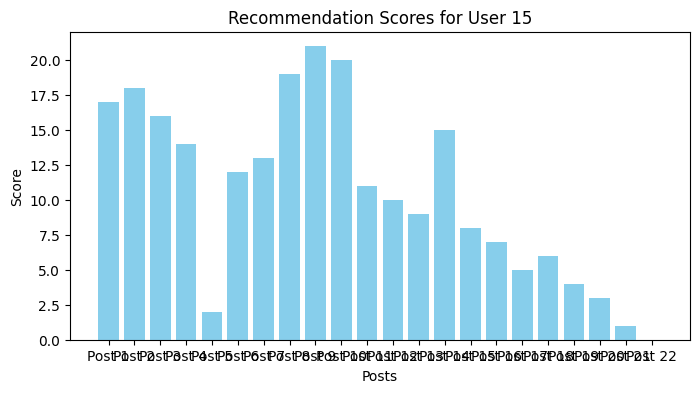

In [4]:

# Buat rekomendasi untuk semua pengguna dan simpan dalam dictionary
recommendations = {}
for user_id_str, user_idx in user_ids.items():
    recommended_posts = recommend_posts(user_idx, num_recommendations=10)
    recommended_post_ids = [list(post_ids.keys())[list(post_ids.values()).index(post_idx)] for post_idx in recommended_posts]
    recommendations[user_id_str] = recommended_post_ids

# Visualisasi skor rekomendasi untuk setiap pengguna
for user_idx in range(num_users):
    recommendation_scores = recommend_posts(user_idx, num_recommendations=num_posts)
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(recommendation_scores)), recommendation_scores, color='skyblue')
    plt.title(f'Recommendation Scores for User {user_idx + 1}')
    plt.xlabel('Posts')
    plt.ylabel('Score')
    plt.xticks(range(len(recommendation_scores)), [f'Post {i+1}' for i in range(num_posts)])
    plt.show()

# Save recommendations to a JSON file
with open('recommendations.json', 'w') as f:
    json.dump(recommendations, f)